In [ ]:
!pip install statsmodels==0.12.0

     |████████████████████████████████| 9.5 MB 5.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from google_drive_downloader import GoogleDriveDownloader as gdd 
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams["figure.figsize"] = (18, 8)

# sns.set(style='whitegrid', palette="bright")
sns.set_theme()
sns.set(font_scale = 1.25)

FONT_SIZE=14


In [ ]:
gdd.download_file_from_google_drive(file_id = '1p4azCzZlFR5KZNVa4bG-LrZZtx0lPds1', dest_path = '/hour.csv')

In [ ]:
df = pd.read_csv('/hour.csv', parse_dates=['mnth'])

##EDA and Preprocessing

In [ ]:
df.drop(columns = ['instant'] , inplace=True)

for i in range(0,24):
  df.hr.loc[df.hr == i] = f'{i}:00:00'

df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0:00:00,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1:00:00,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2:00:00,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3:00:00,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4:00:00,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
data = df.copy()
data.drop(columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'], inplace = True)
data['date'] = data['dteday'].astype('str') + " " + data['hr'].astype('str')

data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d %H")
data = data.sort_values("date").reset_index(drop = True)

data = data.set_index(pd.DatetimeIndex(data['date']))
data.drop(columns = ['dteday', 'hr', 'date'], inplace = True)
data.head()

,cnt
date,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


In [ ]:
#Dataset is clear
data.isnull().sum()

cnt    0
dtype: int64

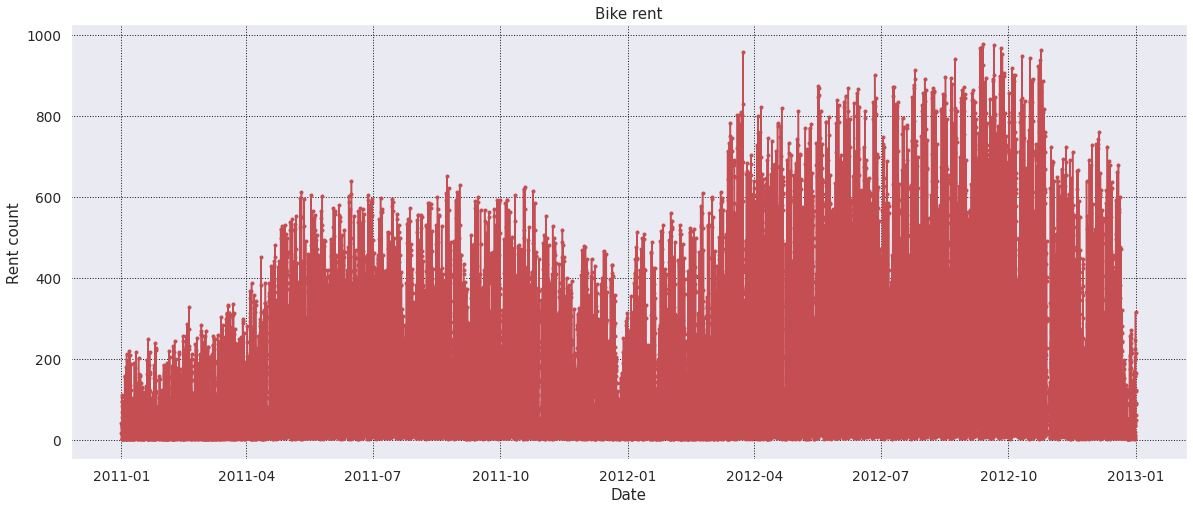

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))
plt.plot(data, '-ro', markersize=3)

plt.plot(data.index[0], 0)

plt.grid(linestyle=':', color='k')
plt.title("Bike rent")
plt.xlabel("Date")
plt.ylabel("Rent count")
plt.show()

In [ ]:
#Let's take a look at Dickey–Fuller test
alpha = 0.05
print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(data['cnt'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
  print("The process is stationary.\n")
else:
  print("The process is non-stationary.\n")  

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -6.8229187118950945
p-value: 1.980862627797809e-09
The process is stationary.



In [ ]:
#And now to KPSS test
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(data['cnt'], regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
  print("The process is non-stationary.\n")
else:
  print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 18.05444985761808
p-value = 0.01
The process is non-stationary.



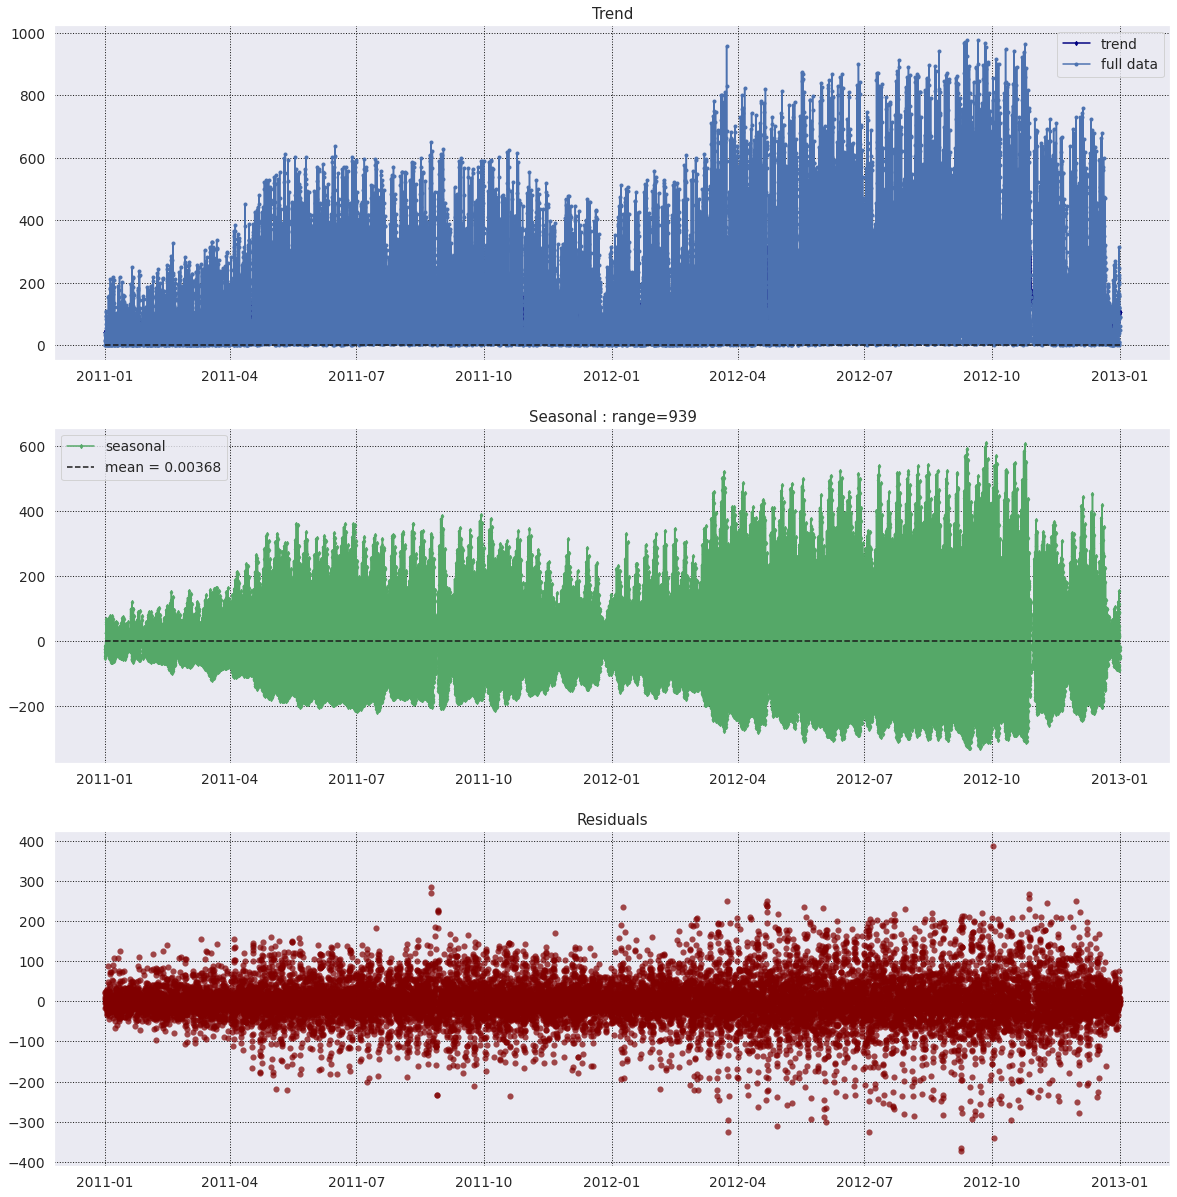

In [ ]:
stl_r = STL(data['cnt'], period=24)
decomposition = stl_r.fit()

plt.subplots(3, 1, figsize=(20, 21))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, 
         '-d', color='navy', markersize=3, label='trend')
plt.plot(data, '-bo', markersize=3, label='full data')

plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")


plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, 
         '-gd', markersize=3, label='seasonal')
plt.plot([decomposition.seasonal.index[0], decomposition.seasonal.index[-1]], 
         decomposition.seasonal.mean()*np.array([1, 1]), '--k', 
         label=f"mean = {decomposition.seasonal.mean():.3g}")
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


plt.subplot(3, 1, 3)

plt.scatter(x=decomposition.resid.index, y= decomposition.resid, color='maroon', alpha= 0.7, linewidths=0.1)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")
plt.show()

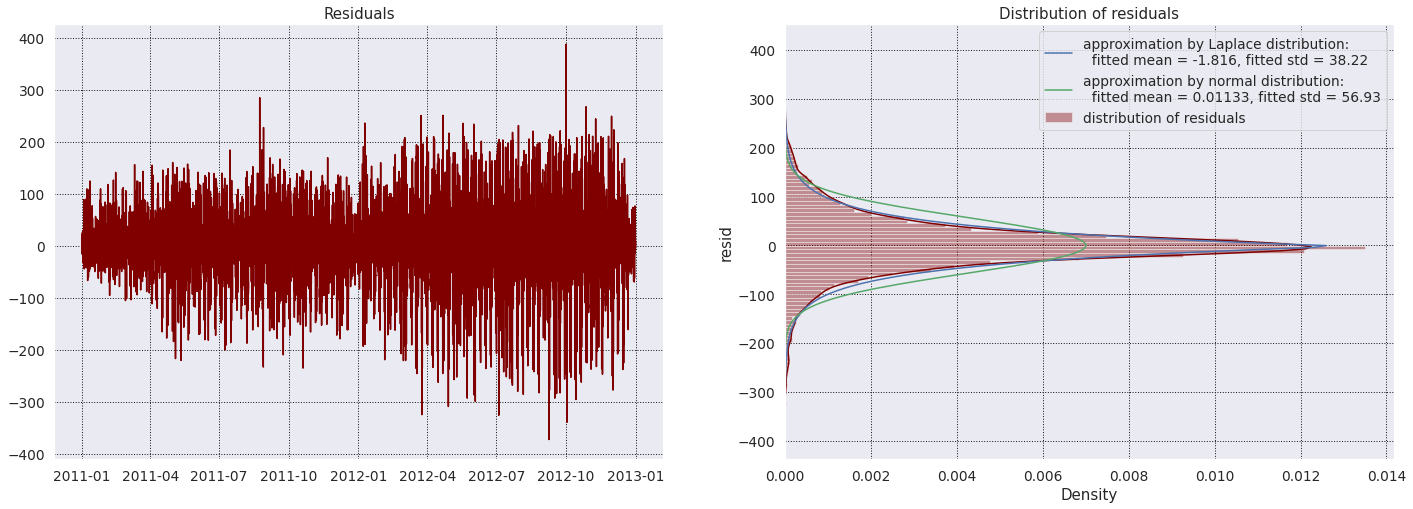

In [ ]:
resid = decomposition.resid
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")



x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())
# print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b', 
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g', 
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()
# plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

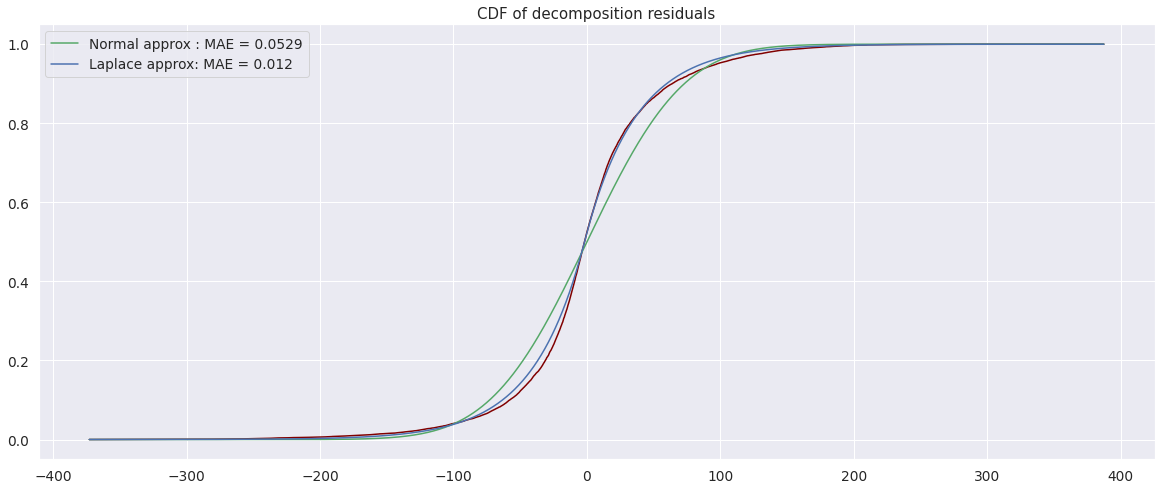

4.403531861739483


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g', 
         label=f"Normal approx : MAE = {mae_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b', 
         label=f"Laplace approx: MAE = {mae_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(mae_norm/mae_laplace)

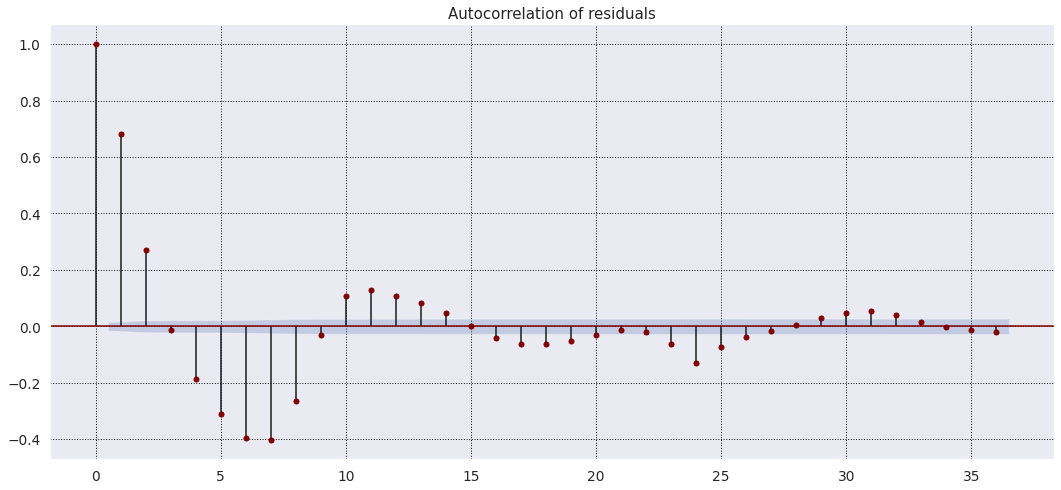

In [ ]:
lags = 36

plot_acf(resid.dropna(), lags=lags, color='maroon', 
         title='Autocorrelation of residuals');
plt.grid(linestyle=':', color='k')

In [ ]:
#Test for trend stationarity
trend = decomposition.trend.dropna()

In [ ]:
alpha = 0.05


print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(trend.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
  print("The process is stationary.\n")
else:
  print("The process is non-stationary.\n") 

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -4.007699181818726
p-value: 0.0013707283369744335
The process is stationary.



In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(trend.dropna(), regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
  print("The process is non-stationary.\n")
else:
  print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 18.657542402416038
p-value = 0.01
The process is non-stationary.



Text(0.5, 1.0, 'Trend')

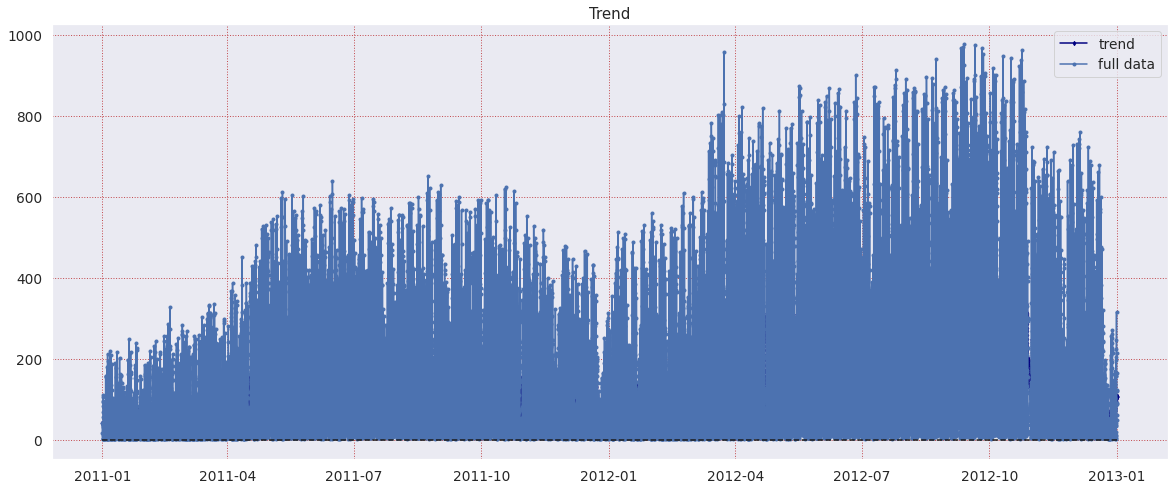

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend, '-d', color='navy', markersize=3, label='trend')
plt.plot(data, '-bo', markersize=3, label='full data')
plt.plot(decomposition.trend.index[0], 0)
plt.plot([trend.index[0], trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")

Text(0.5, 1.0, '1st derivative of trend')

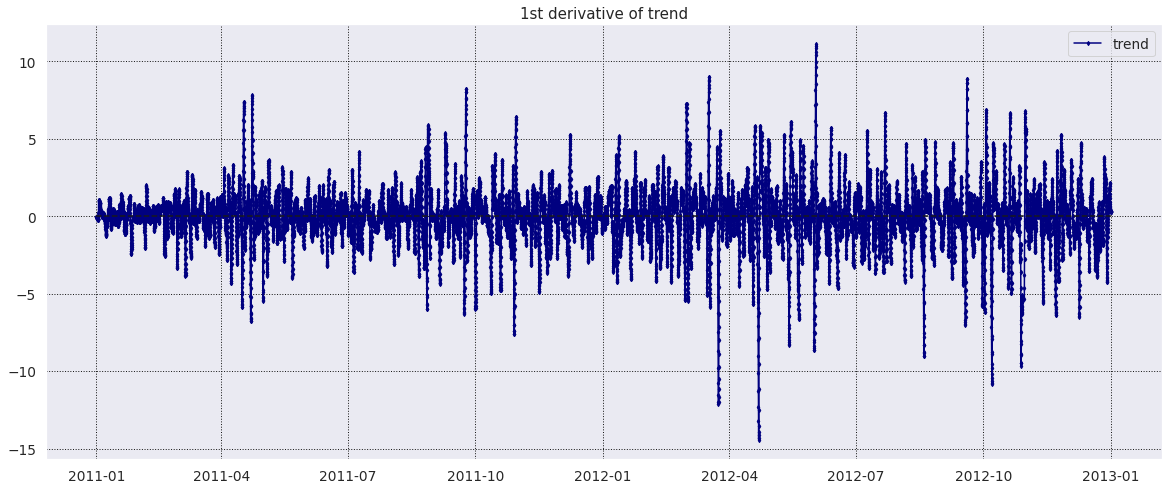

In [ ]:
trend_diff = trend.diff().dropna()

plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([trend_diff.index[0], trend_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("1st derivative of trend")

In [ ]:
alpha = 0.05


print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(trend_diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
  print("The process is stationary.\n")
else:
  print("The process is non-stationary.\n") 

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -21.96262150944158
p-value: 0.0
The process is stationary.



In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(trend_diff, regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
  print("The process is non-stationary.\n")
else:
  print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.023451839065264737
p-value = 0.1
The process is stationary.



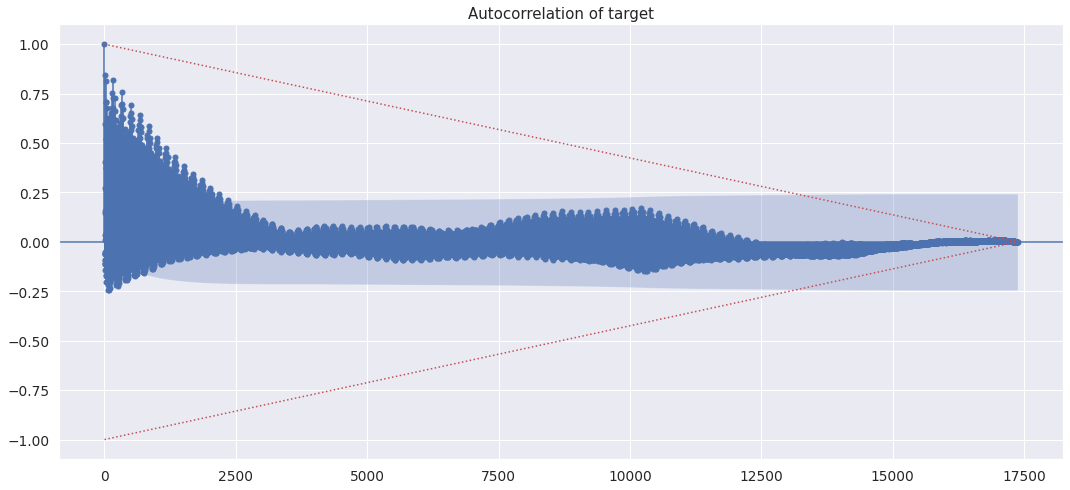

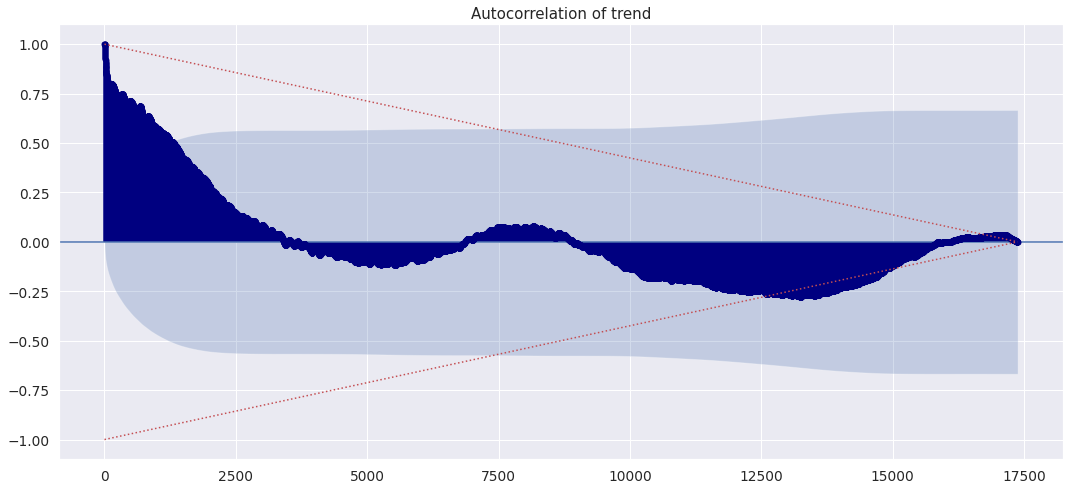

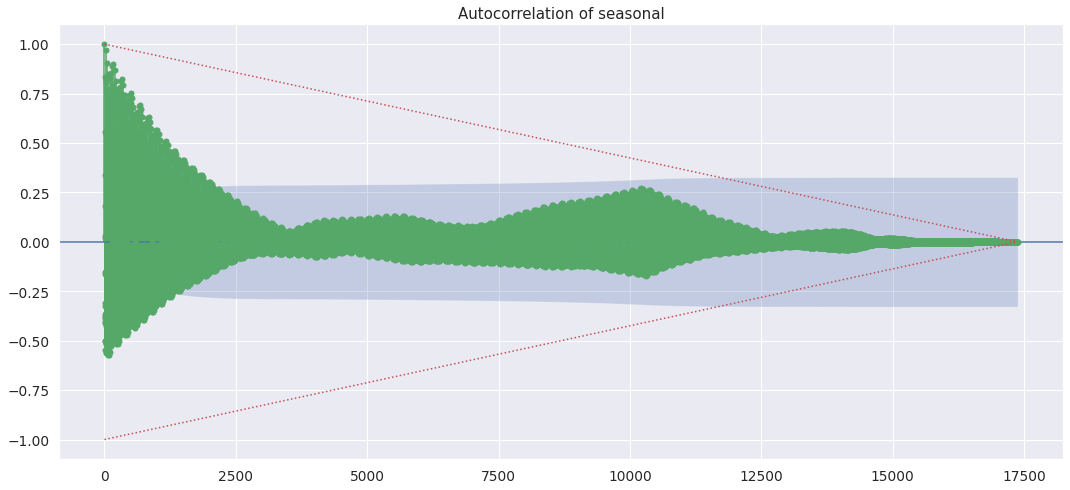

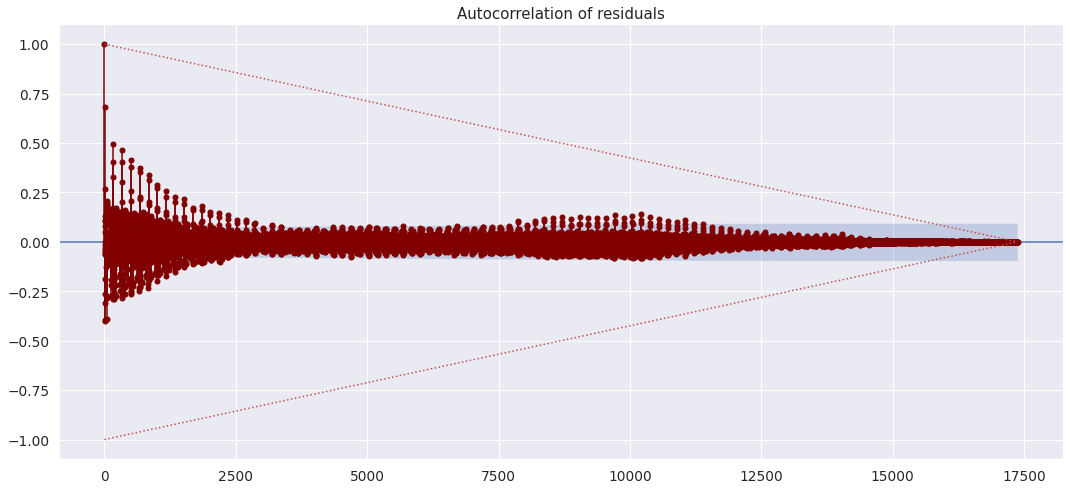

In [ ]:
#Correlation Analysis

N = len(data['cnt'])
k = np.arange(0, N)
plot_acf(data['cnt'], 
         lags=N-1, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(trend.dropna())
k = np.arange(0, N)
plot_acf(trend.dropna(), 
         lags=N-1, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
k = np.arange(0, N)
plot_acf(seasonal, 
         lags=N-1, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
k = np.arange(0, N)
plot_acf(resid.dropna(), 
         lags=N-1,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

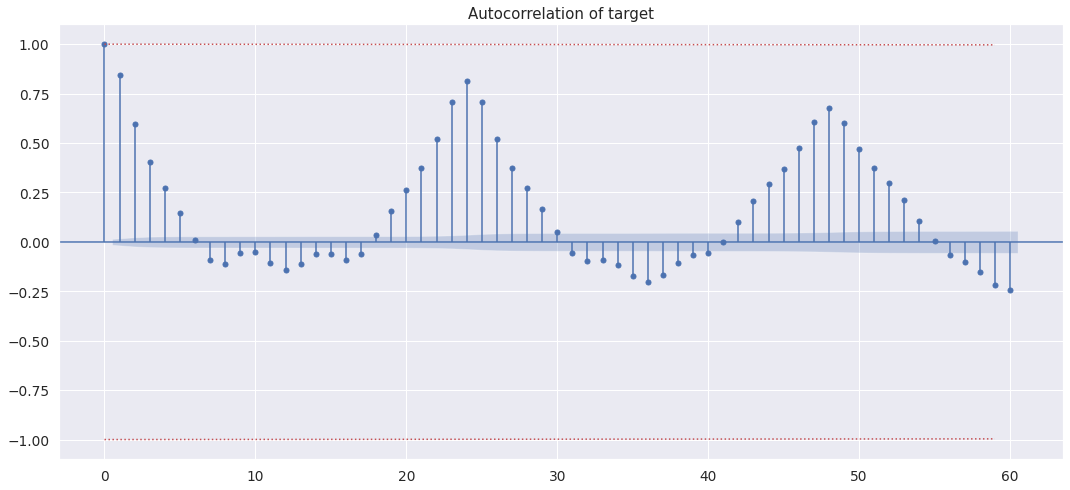

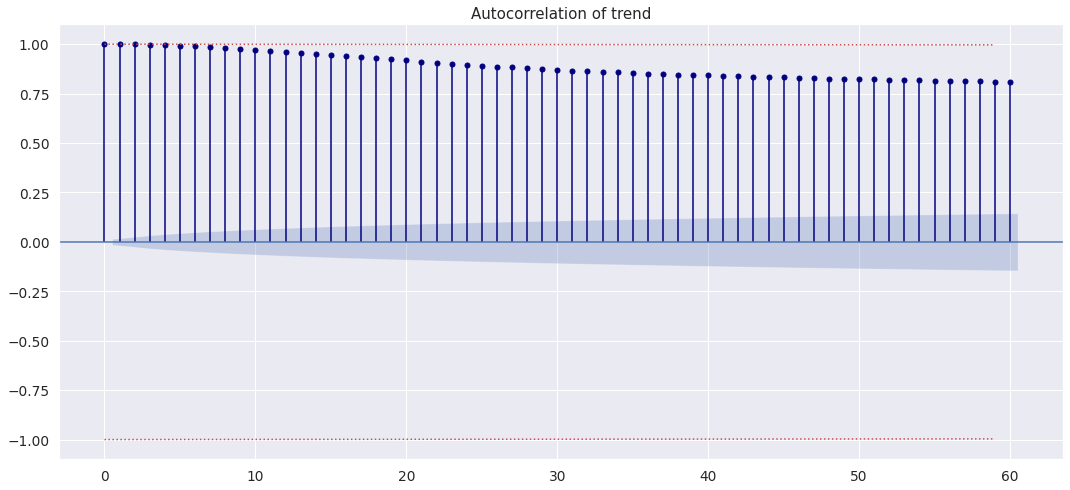

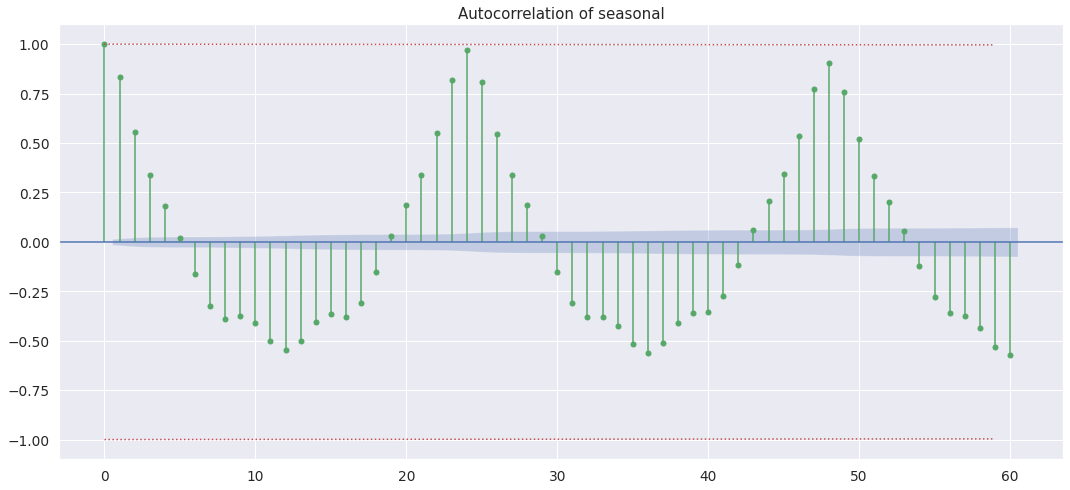

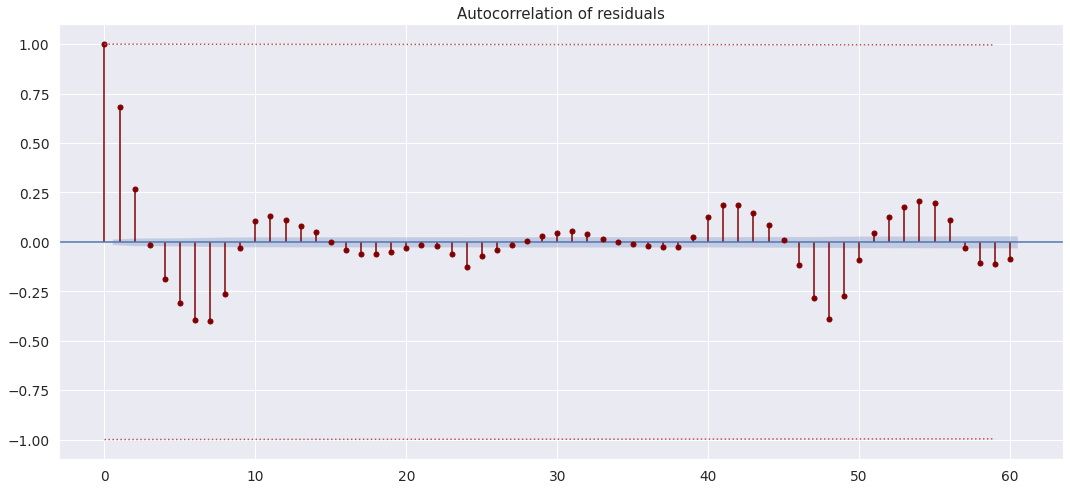

In [ ]:
lags = 60

N = len(data['cnt'])
k = np.arange(0, lags)
plot_acf(data['cnt'], 
         lags=lags, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(trend.dropna())
plot_acf(trend.dropna(), 
         lags=lags, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
plot_acf(seasonal, 
         lags=lags, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
plot_acf(resid.dropna(), 
         lags=lags,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

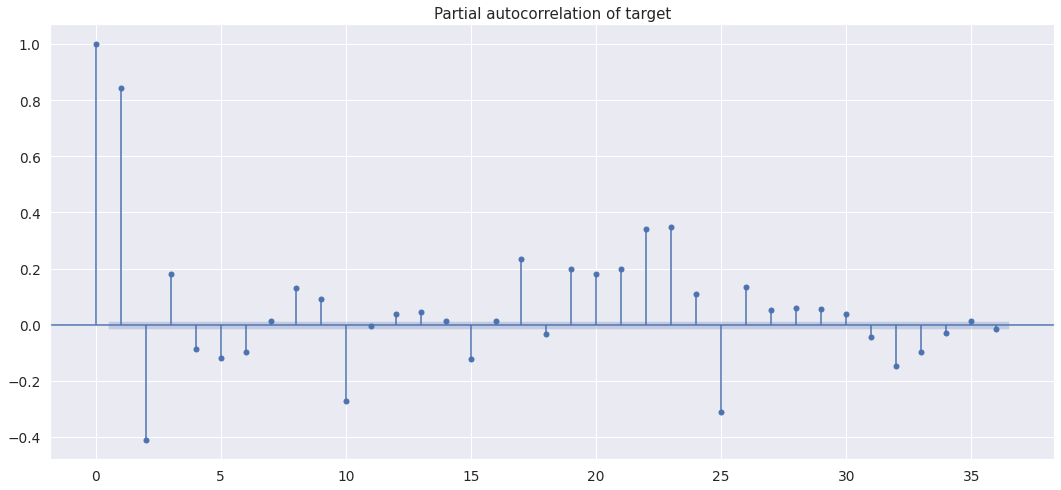

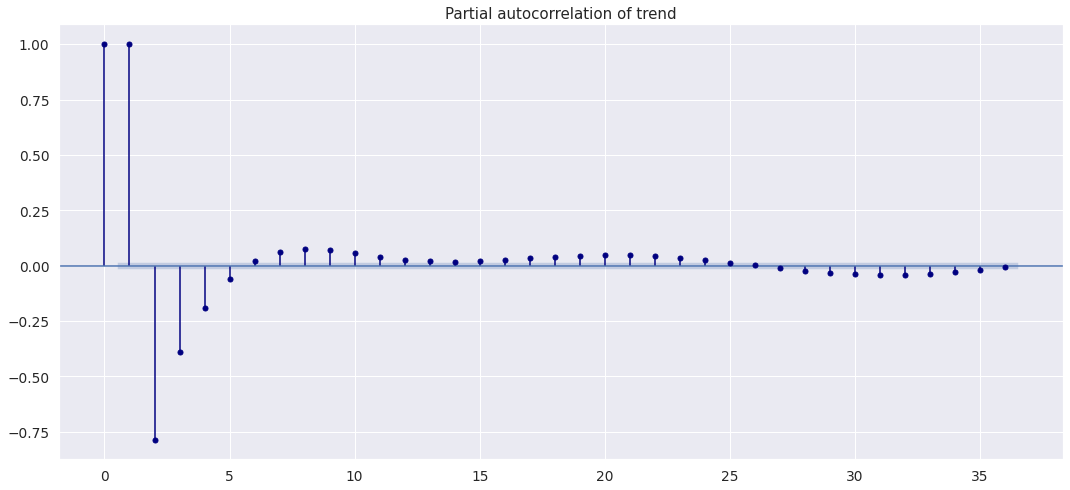

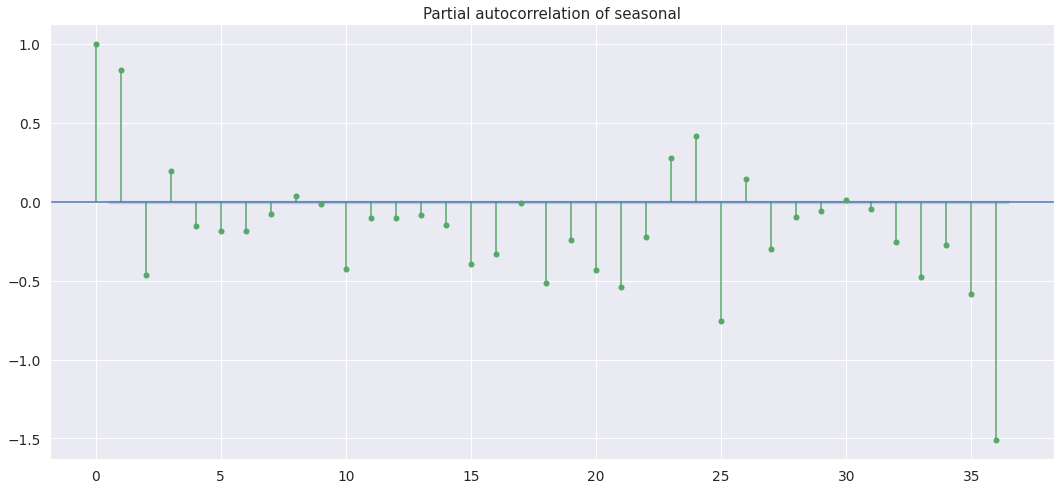

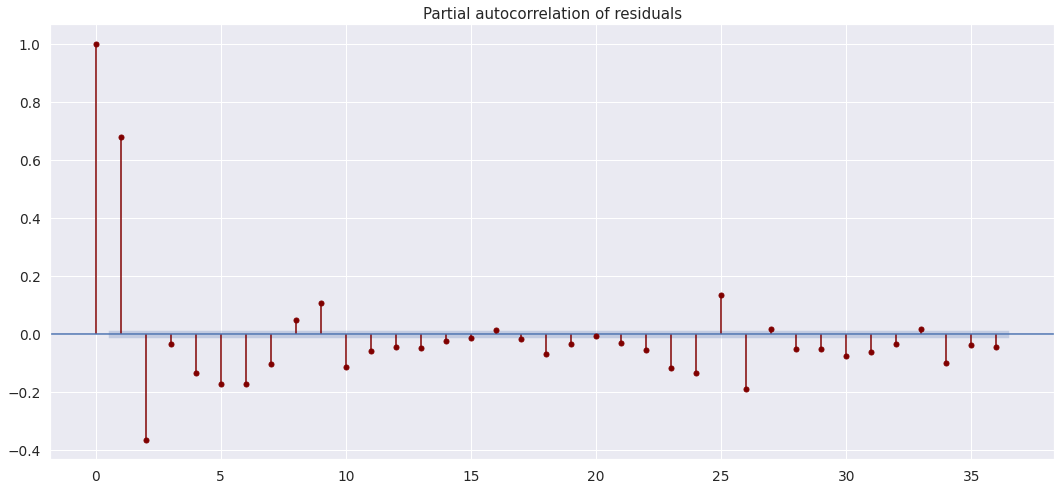

In [ ]:
lags = 36

plot_pacf(data['cnt'], 
         lags=lags, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Partial autocorrelation of target');
         

plot_pacf(trend.dropna(), 
         lags=lags, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Partial autocorrelation of trend');


seasonal = decomposition.seasonal
plot_pacf(seasonal, 
         lags=lags, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Partial autocorrelation of seasonal');


plot_pacf(resid.dropna(), 
         lags=lags,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Partial autocorrelation of residuals');


plt.show()

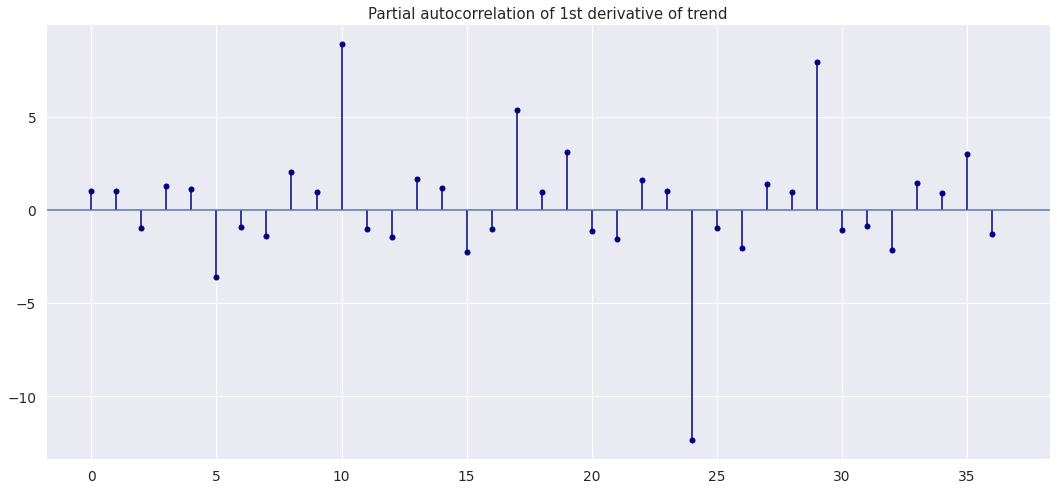

In [ ]:
plot_pacf(trend.dropna().diff().dropna(), 
         lags=lags, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Partial autocorrelation of 1st derivative of trend');

##Linear Reg with endogenous features


In [ ]:
data_enodg = data
data_enodg['seasonal'], data_enodg['trend'] = decomposition.seasonal, decomposition.trend

In [ ]:
X_train, y_train, X_test, y_test = data_enodg[['trend', 'seasonal']].loc[data_enodg.index < '2012-12-1 00:00:00'], \
                                   data_enodg['cnt'].loc[data_enodg.index < '2012-12-1 00:00:00'], \
                                   data_enodg[['trend', 'seasonal']].loc[data_enodg.index >= '2012-12-1 00:00:00'], \
                                   data_enodg['cnt'].loc[data_enodg.index >= '2012-12-1 00:00:00']

In [ ]:
lin_reg_endog = GridSearchCV(ElasticNet(), 
        {
            'alpha': np.linspace(0, 300, 10),
            'l1_ratio': np.arange(0, 1.1, 0.1)
        }, 
        n_jobs=-1, 
         scoring=['neg_mean_squared_error', 'r2'], 
         refit='neg_mean_squared_error',
         cv=3)

lin_reg_endog.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([  0.        ,  33.33333333,  66.66666667, 100.        ,
       133.33333333, 166.66666667, 200.        , 233.33333333,
       266.66666667, 300.        ]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=False, scoring=['neg_mean_squared_error', 'r2'],
             verbose=0)

In [ ]:
y_pred_lin_reg_endog = lin_reg_endog.predict(X_test)

In [ ]:
pd.DataFrame({
        'test_R2' : [r2_score(y_test, y_pred_lin_reg_endog)],
        'test_MAE': [mean_absolute_error(y_pred_lin_reg_endog, y_test)]
    })

,test_R2,test_MAE
0,0.903839,33.502744


## Linear Reg with exogenous features

In [ ]:
data_all = df.copy()
data_all.drop(columns = ['season', 'yr', 'mnth', 'weekday', 'casual', 'registered'], inplace = True)

data_all['date'] = data_all['dteday'].astype('str') + " " + data_all['hr'].astype('str')
data_all['date'] = pd.to_datetime(data_all['date'], format="%Y-%m-%d %H")
data_all = data_all.sort_values("date").reset_index(drop=True)

data_all = data_all[['date', 'cnt', 'holiday',	'workingday',	'weathersit',	'temp',	'atemp',	'hum',	'windspeed']]
data_all = data_all.set_index(pd.DatetimeIndex(data_all['date']))
data_all.drop(columns = ['date'], inplace = True)

In [ ]:
data_all.head()

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
date,,,,,,,,
2011-01-01 00:00:00,16,0,0,1,0.24,0.2879,0.81,0.0
2011-01-01 01:00:00,40,0,0,1,0.22,0.2727,0.80,0.0
2011-01-01 02:00:00,32,0,0,1,0.22,0.2727,0.80,0.0
2011-01-01 03:00:00,13,0,0,1,0.24,0.2879,0.75,0.0
2011-01-01 04:00:00,1,0,0,1,0.24,0.2879,0.75,0.0


In [ ]:
data_all['trend'], data_all['seasonal'] = decomposition.trend, decomposition.seasonal

In [ ]:
X, y = data_all.columns[1:10], data_all.columns[0]

In [ ]:
X_train, X_test, y_train, y_test = data_all[X].loc[data_all.index < '2012-12-1 00:00:00'], \
                                   data_all[X].loc[data_all.index >= '2012-12-1 00:00:00'], \
                                   data_all[y].loc[data_all.index < '2012-12-1 00:00:00'], \
                                   data_all[y].loc[data_all.index >= '2012-12-1 00:00:00']

In [ ]:
lin_reg_exog = GridSearchCV(ElasticNet(), 
        {
            'alpha': np.linspace(0, 300, 10),
            'l1_ratio': np.arange(0, 1.1, 0.1)
        }, 
        n_jobs=-1, 
         scoring=['neg_mean_squared_error', 'r2'], 
         refit='neg_mean_squared_error',
         cv=3)

lin_reg_exog.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([  0.        ,  33.33333333,  66.66666667, 100.        ,
       133.33333333, 166.66666667, 200.        , 233.33333333,
       266.66666667, 300.        ]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=False, scoring=['neg_mean_squared_error', 'r2'],
             verbose=0)

In [ ]:
y_pred_lin_reg_exog = lin_reg_exog.predict(X_test)

In [ ]:
#A little bit worse, but still ok
pd.DataFrame({
        'test_R2' : [r2_score(y_test, y_pred_lin_reg_exog)],
        'test_MAE': [mean_absolute_error(y_pred_lin_reg_exog, y_test)]
    })

,test_R2,test_MAE
0,0.906135,33.846187


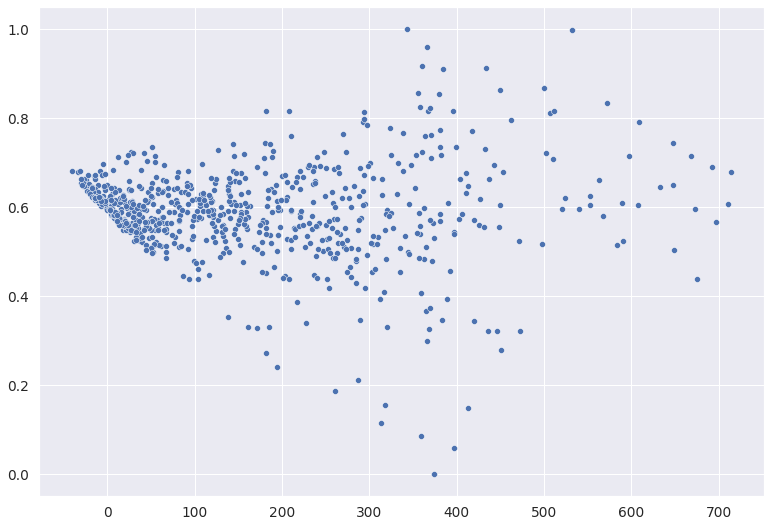

In [ ]:
err = y_test.values - y_pred_lin_reg_exog.reshape(1, -1)[0]

scaler = MinMaxScaler()
err_transform = scaler.fit_transform(err.reshape(-1,1))

f, ax = plt.subplots(figsize=(13,9))
sns.scatterplot(x= y_pred_lin_reg_exog.reshape(1,-1)[0], y= err_transform.reshape(1,-1)[0])

## ARIMA

In [ ]:
train_arima, test_arima = data.loc[(data.index < '2012-12-1 00:00:00')], \
                                    data.loc[data.index >= '2012-12-1 00:00:00']

In [ ]:
p, d, q = 24, 0, 24

arima_model = ARIMA(train_arima, order=(p, d, q)).fit()
print()
print(f"ARIMA model ({p}, {d}, {q}):")
print(arima_model.params)

prediction_arima_train = arima_model.predict(train_arima.index[0], train_arima.index[-1])
prediction_arima_test = arima_model.predict(test_arima.index[0], test_arima.index[-1])

mae_arima = mean_absolute_error(y_true=test_arima, y_pred=prediction_arima_test)


plt.plot(data_arima.index, data_arima, '-b', label="data")
plt.plot(arima_model.fittedvalues, '-r', label="train fitted values")
plt.plot(test_arima.index, prediction_arima_test, '-g', label=f"prediction, MAE = {mae_arima:0.3f}")
plt.grid(linestyle=':')
plt.legend()
plt.title(f"ARIMA {(p, d, q)}")
plt.show()

In [ ]:
plt.plot(test_arima.index, test_arima, '-bo', label="data")
plt.plot(test_arima.index, prediction_arima_test, '-g', label=f"ARIMA{(p, d, q)}: MAE = {mae_arima:0.3f}")
plt.grid(linestyle=':', color='k')
plt.legend()
plt.title("Predictions")
plt.show()

## SARIMAX

In [ ]:
train_endog_sarimax = data_all['cnt'].loc[(data_all.index < '2012-12-1 00:00:00')]
test_endog_sarimax = data_all['cnt'].loc[(data_all.index >= '2012-12-1 00:00:00')]
train_exog_sarimax = data_all[['holiday',	'workingday',	'weathersit',	'temp',	'atemp',	'hum',	'windspeed', 'trend',	'seasonal',]].loc[(data_all.index < '2012-12-1 00:00:00')]
test_exog_sarimax = data_all[['holiday',	'workingday',	'weathersit',	'temp',	'atemp',	'hum',	'windspeed', 'trend',	'seasonal',]].loc[(data_all.index >= '2012-12-1 00:00:00')]

In [ ]:
p, d, q = 24, 0, 24

SARIMAX_model = SARIMAX(test_endog_sarimax, train_exog_sarimax).fit()

print(SARIMAX_model.summary())

ValueError: ignored

In [ ]:
prediction_train_SARIMAX = SARIMAX_model.predict(exog= train_exog_sarimax)
prediction_test_SARIMAX = SARIMAX_model.predict(exog= test_exog_sarimax)

mae_sarimax = mean_absolute_error(y_true=test_endog_sarimax, y_pred=prediction_test_SARIMAX)

plt.plot(data_full.index, data_full, '-b', label="data")
plt.plot(SARIMAX_model.fittedvalues, '-r', label="train fitted values")
plt.plot(test_endog_sarimax.index, prediction_test_SARIMAX, '-g', label=f"prediction and MAE = {mae_sarimax:0.5f}")
plt.grid(linestyle=':')
plt.legend()
plt.title(f"ARIMA {(p, d, q)}")
plt.show()

In [ ]:
plt.plot(test_SARIMAX.index, test_SARIMAX, '-bo', label="data")
plt.plot(test_SARIMAX.index, prediction_test_SARIMAX, '-g', label=f"ARIMA{(p, d, q)}: MAE = {mae_SARIMAX:0.3f}")
plt.grid(linestyle=':', color='k')
plt.legend()
plt.title("Predictions")
plt.show()

## Decision Tree

In [ ]:
#Decision Tree Regressor 
dtr = GridSearchCV(DecisionTreeRegressor(),{
    'max_depth': [3, 7, 15],
    'min_samples_split': [0.2, 0.5, 1, 2],
    'min_samples_leaf':[0.1, 0.5, 2],
    'max_features': ['sqrt', 'log2', 'auto']
}, cv = 5, return_train_score = False)

dtr.fit(X_train, y_train)
pd.DataFrame(dtr.cv_results_)[['param_max_depth','param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'mean_test_score']].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score
0,3,0.2,0.1,sqrt,0.216203
1,3,0.5,0.1,sqrt,0.074557
2,3,1,0.1,sqrt,NaN
3,3,2,0.1,sqrt,0.217430
4,3,0.2,0.5,sqrt,-0.249044


In [ ]:
y_pred_dtr = dtr.predict(X_test)

In [ ]:
pd.DataFrame({
        'test_R2' : [r2_score(y_test, y_pred_dtr)],
        'test_MAE': [mean_absolute_error(y_pred_dtr, y_test)]
    })

,test_R2,test_MAE
0,0.894791,35.78809
